In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from aeon.datasets import load_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from art.estimators.classification import PyTorchClassifier
import random 
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets
import pandas as pd
import matplotlib.pyplot as plt
import os

from CNN_Models import BaseCNN1D


random.seed(420)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


## Prepare data

In [13]:
def load_data(dataset):
    X_train, y_train = load_classification(dataset, split="train")
    X_test0, y_test0 = load_classification(dataset, split="test")
    
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test0 = le.fit_transform(y_test0)    

    return X_train, y_train, X_test0, y_test0

dataset = "WalkingSittingStanding"      #also tested for PenDigits

In [14]:
x_train, y_train, X_test0, y_test0 = load_data(dataset)

# Hyperparameters
num_classes = len(np.unique(y_train))
num_epochs = 100
learning_rate = 0.01
batch_size = 128
patience = 10  

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create DataLoaders for train, validation, and test
train_data = torch.utils.data.TensorDataset(torch.FloatTensor(x_train).to(device), torch.LongTensor(y_train).to(device))
val_data = torch.utils.data.TensorDataset(torch.FloatTensor(x_val).to(device), torch.LongTensor(y_val).to(device))
test_data = torch.utils.data.TensorDataset(torch.FloatTensor(X_test0).to(device), torch.LongTensor(y_test0).to(device))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f'Samples in training dataset: {len(train_data)}')
print(f'Samples in validation dataset: {len(val_data)}')
print(f'Samples in test dataset: {len(test_data)}')

Samples in training dataset: 6616
Samples in validation dataset: 736
Samples in test dataset: 2947


## Train model

In [16]:
model = BaseCNN1D(num_classes=num_classes,device=device, num_epochs=num_epochs, learning_rate=learning_rate, patience=patience).cuda()
model.train_model(train_loader, val_loader)

Epoch [1/100], Loss: 1.6984, Accuracy: 32.38%
Epoch [2/100], Loss: 1.5055, Accuracy: 56.88%
Epoch [3/100], Loss: 1.4228, Accuracy: 67.47%
Epoch [4/100], Loss: 1.3786, Accuracy: 70.65%
Epoch [5/100], Loss: 1.3509, Accuracy: 72.16%
Validation at Epoch [5/100]: Loss: 1.3756, Accuracy: 69.02%
Epoch [6/100], Loss: 1.3358, Accuracy: 72.84%
Epoch [7/100], Loss: 1.3226, Accuracy: 74.00%
Epoch [8/100], Loss: 1.3177, Accuracy: 74.12%
Epoch [9/100], Loss: 1.3097, Accuracy: 74.49%
Epoch [10/100], Loss: 1.3050, Accuracy: 75.24%
Validation at Epoch [10/100]: Loss: 1.3340, Accuracy: 72.01%
Epoch [11/100], Loss: 1.2986, Accuracy: 75.76%
Epoch [12/100], Loss: 1.2981, Accuracy: 75.45%
Epoch [13/100], Loss: 1.2941, Accuracy: 76.22%
Epoch [14/100], Loss: 1.2906, Accuracy: 76.28%
Epoch [15/100], Loss: 1.2880, Accuracy: 76.51%
Validation at Epoch [15/100]: Loss: 1.3220, Accuracy: 72.83%
Epoch [16/100], Loss: 1.2863, Accuracy: 76.78%
Epoch [17/100], Loss: 1.2840, Accuracy: 76.90%
Epoch [18/100], Loss: 1.2837

## Test model

In [17]:
# Evaluation
with torch.no_grad():
    model.eval()
    test_data = torch.FloatTensor(X_test0).cuda()
    test_labels = torch.LongTensor(y_test0).cuda()
    outputs = model(test_data)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == test_labels).sum().item() / test_labels.size(0)
    print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.6725


## Define original Classifier

In [18]:
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets
from art.estimators.classification import PyTorchClassifier

len_steal = 1000

criterion = nn.CrossEntropyLoss()
optimizer_original = optim.Adam(model.parameters(), lr=learning_rate)
classifier_original = PyTorchClassifier(model=model, loss=criterion, optimizer=optimizer_original, input_shape=(batch_size,x_train.shape[1], x_train.shape[2]), nb_classes=num_classes)
pred = classifier_original.predict(torch.FloatTensor(X_test0))

preds = np.argmax(pred, axis=1)
acc = np.mean(preds == y_test0)
print(f'Test Accuracy: {acc:.4f}')


Test Accuracy: 0.6725


## Run attacks

In [19]:
attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                   }

results = []
percentages = [0.001, 0.005, 0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]  # Generate percentages of samples to run the attacks on

for percentage in percentages:
    len_steal = int(len(X_test0) * percentage) 
    print(f'running attack for {len_steal} samples')
    indices = np.random.permutation(len(X_test0))
    x_steal = X_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = X_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]] 


    for name, attack in attack_catalogue.items():
        model_stolen = BaseCNN1D(num_classes=num_classes, device=device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        classifier_stolen = PyTorchClassifier(model=model_stolen, loss=criterion, optimizer=optimizer, input_shape=(batch_size, x_steal.shape[1], x_steal.shape[2]), nb_classes=num_classes)
        classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)

        pred = classifier_stolen.predict(torch.FloatTensor(x_test))
        
        preds = np.argmax(pred, axis=1)
        acc = np.mean(preds == y_test)
        
        print(name, ":", acc)

        results.append((name, len_steal, acc))

running attack for 2 samples
Probabilistic CopycatCNN : 0.1599320882852292
Argmax CopycatCNN : 0.1772495755517827
Probabilistic KnockoffNets : 0.1799660441426146
Argmax KnockoffNets : 0.18234295415959254
running attack for 14 samples
Probabilistic CopycatCNN : 0.18377088305489261
Argmax CopycatCNN : 0.14251619502216162
Probabilistic KnockoffNets : 0.14251619502216162
Argmax KnockoffNets : 0.1708148653256052
running attack for 29 samples
Probabilistic CopycatCNN : 0.10932145305003427
Argmax CopycatCNN : 0.18060315284441397
Probabilistic KnockoffNets : 0.19328307059629884
Argmax KnockoffNets : 0.14359150102810145
running attack for 147 samples
Probabilistic CopycatCNN : 0.1325
Argmax CopycatCNN : 0.18571428571428572
Probabilistic KnockoffNets : 0.18071428571428572
Argmax KnockoffNets : 0.1682142857142857
running attack for 294 samples
Probabilistic CopycatCNN : 0.1436110064078402
Argmax CopycatCNN : 0.15491895966830005
Probabilistic KnockoffNets : 0.16471918582736525
Argmax KnockoffNets 

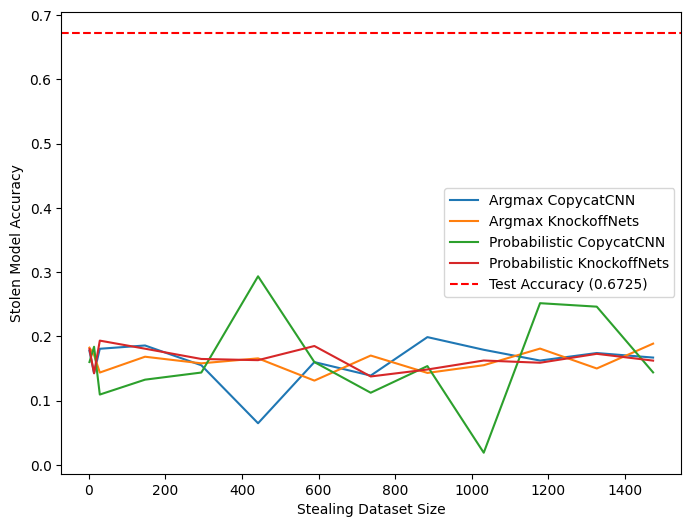

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
    
ax.axhline(y=accuracy, color='r', linestyle='--', 
            label=f"Test Accuracy ({accuracy:.4f})")
ax.legend()
plt.show()